In [1]:
from pathlib import Path

NEW_SVC_FILE = Path(
    r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00028\00028__3_1.svc"
)

print("Using file:", NEW_SVC_FILE)


Using file: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00028\00028__3_1.svc


File: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00028\00028__3_1.svc
  substrokes found: 5
  PD probability: 0.4480  => Predicted label: H (0)  (threshold=0.5)
  input after pad shape: (1, 267, 13)


C:\Users\aibel\AppData\Local\Temp\ipykernel_524\2137256731.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab20')


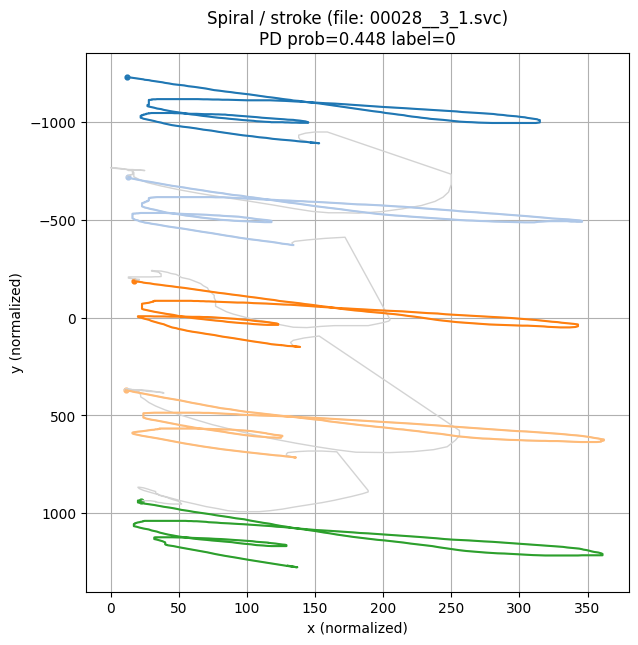

Saved demo result to: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\demo_result_00028__3_1.json


In [2]:
import numpy as np
import pickle
import math
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

PROJECT_DIR = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease")
PROCESSED_DIR = PROJECT_DIR / "data" / "processed"
MODEL_PATH = PROCESSED_DIR / "pd_blstm_model.h5"
IMP_PATH   = PROCESSED_DIR / "imputer.pkl"
SCALER_PATH= PROCESSED_DIR / "scaler.pkl"


NEW_SVC_FILE = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00028\00028__3_1.svc")


try:
    cap  
except NameError:
    cap = 267


model = tf.keras.models.load_model(MODEL_PATH)
with open(IMP_PATH, "rb") as f:
    imputer = pickle.load(f)
with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)


def load_svc_simple(pth):
    rows = []
    with open(pth, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            parts = ln.strip().split()
            if len(parts) < 7:
                continue
            try:
                if len(parts) == 8:
                    _, x, y, ts, pen, azim, alt, press = parts
                elif len(parts) == 7:
                    x, y, ts, pen, azim, alt, press = parts
                else:
                    x, y, ts, pen, azim, alt, press = parts[-7:]
                rows.append([float(x), float(y), float(ts), int(pen), float(azim), float(alt), float(press)])
            except:
                continue
    if len(rows) == 0:
        return None
    df = pd.DataFrame(rows, columns=["x","y","time","pen","azim","alt","press"])
  
    df["time_s"] = df["time"] - df["time"].min()
    df["x_s"] = df["x"] - df["x"].min()
    df["y_s"] = df["y"] - df["y"].mean()
    df["dt"] = df["time_s"].diff().fillna(0.0).replace(0,1e-6)
    df["vx"] = df["x_s"].diff().fillna(0.0) / df["dt"]
    df["vy"] = df["y_s"].diff().fillna(0.0) / df["dt"]
    df["speed"] = np.sqrt(df["vx"]**2 + df["vy"]**2).fillna(0.0)
    df["ax"] = df["vx"].diff().fillna(0.0) / df["dt"]
    df["ay"] = df["vy"].diff().fillna(0.0) / df["dt"]
    df["accel"] = np.sqrt(df["ax"]**2 + df["ay"]**2)
    df["theta"] = np.arctan2(df["vy"], df["vx"])
    df["curvature"] = np.abs(df["theta"].diff().fillna(0.0)) / df["dt"].replace(0,1e-6)
    return df


use_helpers = True
try:

    load_svc
    preprocess_df
    segment_by_pen
    split_all_strokes
    fit_beta_to_substroke
    fit_ellipse_least_squares
    compute_substroke_feature_vector
except Exception:
    use_helpers = False


if use_helpers:
    try:
        df = load_svc(NEW_SVC_FILE)
        df = preprocess_df(df)
    except Exception:
        df = load_svc_simple(NEW_SVC_FILE)
        use_helpers = False
else:
    df = load_svc_simple(NEW_SVC_FILE)

if df is None or len(df) == 0:
    raise RuntimeError(f"No valid rows parsed from {NEW_SVC_FILE}")

if use_helpers:
    try:
        pen_strokes = segment_by_pen(df)
        subs = split_all_strokes(df, pen_strokes, prom=0.05, dist=8, min_points=6)
    except Exception:
        use_helpers = False

if not use_helpers:
    subs = []
    pen = df["pen"].to_numpy()
    start = None
    for i,v in enumerate(pen):
        if v == 1 and start is None:
            start = i
        if (v == 0 or i == len(pen)-1) and start is not None:
            end = i if v==0 else i
            if end - start + 1 >= 6:
                subs.append((start, end))
            start = None
    if len(subs) == 0:
        subs = [(0, len(df)-1)]

feat_list = []
for (s,e) in subs:
    seg = df.iloc[s:e+1].reset_index(drop=True)
    if len(seg) < 6:
        continue
    if use_helpers:
        try:
            vec = compute_substroke_feature_vector(seg, df, s, e)
        except Exception:
            use_helpers = False
    if not use_helpers:
        duration = seg['time_s'].iloc[-1] - seg['time_s'].iloc[0]
        amp_x = seg['x_s'].max() - seg['x_s'].min()
        amp_y = seg['y_s'].max() - seg['y_s'].min()
        amplitude = math.sqrt(amp_x**2 + amp_y**2)
        mean_speed = seg['speed'].mean()
        mean_press = seg['press'].mean()
        beta_A = np.nan; beta_a = np.nan; beta_b = np.nan
        ell_a = np.nan; ell_b = np.nan; ell_ecc = np.nan
        f_speed_high = 1.0 if mean_speed > np.nanmedian(df['speed']) else 0.0
        f_press_high = 1.0 if mean_press > np.nanmedian(df['press']) else 0.0
        f_curv_high  = 1.0 if seg['curvature'].mean() > np.nanmedian(df['curvature']) else 0.0
        vec = np.array([duration, amplitude, mean_speed, mean_press,
                        beta_A, beta_a, beta_b, ell_a, ell_b, ell_ecc,
                        f_speed_high, f_press_high, f_curv_high], dtype=float)
    feat_list.append(vec)

if len(feat_list) == 0:
    raise RuntimeError("No usable substrokes found for prediction.")

seq_arr = np.vstack(feat_list)   

seq_arr[np.isposinf(seq_arr)] = np.nan
seq_arr[np.isneginf(seq_arr)] = np.nan
seq_imputed = imputer.transform(seq_arr)
seq_scaled = scaler.transform(seq_imputed)

seq_fixed = seq_scaled.copy()
if seq_fixed.shape[0] > cap:
    seq_fixed = seq_fixed[:cap, :]
elif seq_fixed.shape[0] < cap:
    pad_len = cap - seq_fixed.shape[0]
    pad_block = np.zeros((pad_len, seq_fixed.shape[1]), dtype=np.float32)
    seq_fixed = np.vstack([seq_fixed, pad_block])
X_demo = np.expand_dims(seq_fixed.astype(np.float32), axis=0)  

prob = float(model.predict(X_demo, verbose=0).ravel()[0])
label = 1 if prob >= 0.5 else 0
label_str = "PD" if label == 1 else "H"


print(f"File: {NEW_SVC_FILE}")
print(f"  substrokes found: {len(feat_list)}")
print(f"  PD probability: {prob:.4f}  => Predicted label: {label_str} ({label})  (threshold=0.5)")
print(f"  input after pad shape: {X_demo.shape}")

plt.figure(figsize=(7,7))
plt.title(f"Spiral / stroke (file: {NEW_SVC_FILE.name})\nPD prob={prob:.3f} label={label}")
plt.plot(df['x_s'], df['y_s'], color='lightgray', linewidth=1, label='stroke path')
cmap = mpl.cm.get_cmap('tab20')
for i,(s,e) in enumerate(subs):
    seg = df.iloc[s:e+1]
    col = cmap(i % 20)
    plt.plot(seg['x_s'], seg['y_s'], color=col, linewidth=1.5)
    plt.scatter(seg['x_s'].iloc[0], seg['y_s'].iloc[0], color=col, s=12)
plt.gca().invert_yaxis()  
plt.xlabel("x (normalized)")
plt.ylabel("y (normalized)")
plt.legend([],[], frameon=False)
plt.grid(True)
plt.show()

out = {
    "file": str(NEW_SVC_FILE),
    "n_substrokes": int(len(feat_list)),
    "prob": float(prob),
    "label": int(label)
}
OUT_JSON = PROCESSED_DIR / f"demo_result_{NEW_SVC_FILE.stem}.json"
with open(OUT_JSON, "w") as f:
    import json
    json.dump(out, f, indent=2)
print("Saved demo result to:", OUT_JSON)
